# Similarity Classification

In [1]:
import os
import glob
import csv
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

#### Parameters

In [2]:
path = os.path.join(os.environ['DATASETS'], 'logos')
logos_name = os.path.join(path, 'logos', 'all_crops.zip')
logos_128_name = os.path.join(path, 'logos', 'all_crops_128x128.zip')
exemplars_name = os.path.join(path, 'exemplars', 'exemplars.zip')

#### Load data

In [3]:
logos_df = pd.read_pickle(logos_name)
logos_128_df = pd.read_pickle(logos_128_name)
exemplars_df = pd.read_pickle(exemplars_name)

logos_df.head()

,brand,img_vec
0,1fck?ln,"[0.8744431138038635, 0.8719696998596191, 1.115..."
1,24fitness,"[0.8141988515853882, 0.8745986223220825, 0.998..."
2,3m,"[0.9014615416526794, 0.9498094916343689, 1.013..."
3,3m,"[0.8424268960952759, 0.8969314098358154, 1.006..."
4,3m,"[0.9028753638267517, 0.9141451120376587, 1.117..."


#### Filter data

In [4]:
logos_brands = Counter(logos_df['brand'])
logos_list = [b for b, c in logos_brands.items() if c >= 50]
brands_mask = logos_df['brand'].isin(logos_list)
too_many = logos_df['brand'] == 'heineken'

logos_small_df = logos_df[brands_mask & ~too_many]
logos_128_small_df = logos_128_df[brands_mask & ~too_many]

### Analyze latent space

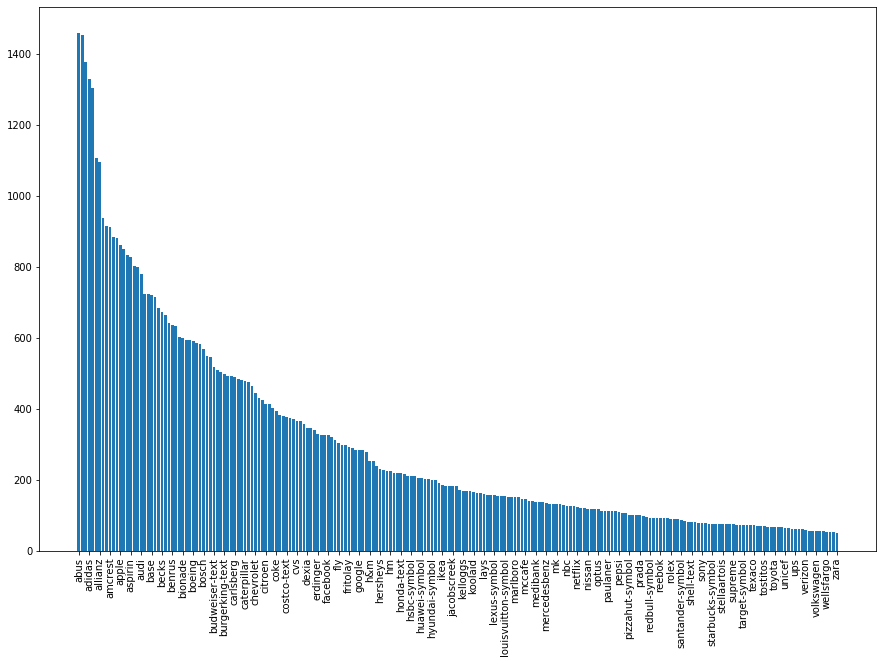

In [5]:
logos_small = Counter(logos_small_df['brand'])
detections_set = set(logos_small_df['brand'])

x, y = zip(*logos_small.most_common())
ticks = [v for i, v in enumerate(x) if i % 3 == 0]
labels = [v for i, v in enumerate(logos_small.keys()) if i % 3 == 0]

plt.figure(figsize=(15, 10))
plt.bar(x, y)
plt.xticks(ticks, labels, rotation='vertical');

In [6]:
def get_distances(exemplars, detections, logos, reference, metric, p=None):
    brands_list = []
    mean_list = []
    min_list = []
    max_list = []
    std_list = []
    var_list = []

    for idx, row in exemplars.iterrows():

        exemplar_brand = row['brand']
        exemplar_vec = row['img_vec']
        if exemplar_brand in detections:

            if reference.lower() == 'tp':
                brand_mask = logos['brand'] == exemplar_brand
            elif reference.lower() == 'fp':
                brand_mask = logos['brand'] != exemplar_brand
            brand_detections = list(logos['img_vec'][brand_mask])

            neigh = KNeighborsClassifier(n_neighbors=1, metric=metric, p=p)
            neigh.fit([exemplar_vec], [1])
            dists, classes = neigh.kneighbors(brand_detections)

            brands_list.append(exemplar_brand)
            mean_list.append(np.mean(dists))
            min_list.append(np.min(dists))
            max_list.append(np.max(dists))
            std_list.append(np.std(dists))
            var_list.append(np.var(dists))

    dists_mat = pd.DataFrame({
        'brand': brands_list,
        'mean': mean_list,
        'min': min_list,
        'max': max_list,
        'std': std_list,
        'var': var_list
        })

    return dists_mat

In [7]:
def plot_distances(mat_1, mat_2, mat_3, mat_4, mat_5, mat_6):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    labels = ['Exem - TPs', 'Exem - FPs']

    data = np.array((mat_1['mean'], mat_4['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[0].boxplot(norm, widths=0.75, labels=labels);
    axs[0].set_title('Minkowski: 1');

    data = np.array((mat_2['mean'], mat_5['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[1].boxplot(norm, widths=0.75, labels=labels);
    axs[1].set_title('Minkowski: 2');

    data = np.array((mat_3['mean'], mat_6['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[2].boxplot(norm, widths=0.75, labels=labels);
    axs[2].set_title('Cosine');

## Crops of varying size

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [8]:
dists_mat_1 = get_distances(exemplars_df, detections_set, logos_small_df, 'TP', metric='minkowski', p=1)

##### Minkowski: 2

In [9]:
dists_mat_2 = get_distances(exemplars_df, detections_set, logos_small_df, 'TP', metric='minkowski', p=2)

#### Cosine

In [10]:
dists_mat_3 = get_distances(exemplars_df, detections_set, logos_small_df, 'TP', metric='cosine')

### Average distance: Exemplar to FPs

##### Minkowski: 1

In [11]:
dists_mat_4 = get_distances(exemplars_df, detections_set, logos_small_df, 'FP', metric='minkowski', p=1)

##### Minkowski: 2

In [12]:
dists_mat_5 = get_distances(exemplars_df, detections_set, logos_small_df, 'FP', metric='minkowski', p=2)

##### Cosine

In [13]:
dists_mat_6 = get_distances(exemplars_df, detections_set, logos_small_df, 'FP', metric='cosine')

### Results

In [14]:
dists_mat_1.describe()

,mean,min,max,std,var
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,57.290330,48.719692,63.466642,2.477221,6.634342
std,1.657303,4.686671,1.577730,0.707063,4.949150
min,51.705260,29.935183,59.144352,1.606710,2.581517
25%,56.373766,45.637823,62.450686,2.030601,4.123340
50%,57.321213,50.261644,63.490425,2.308395,5.328687
75%,58.315143,52.068167,64.478299,2.786064,7.762154
max,61.677231,56.848371,67.946558,7.414708,54.977897


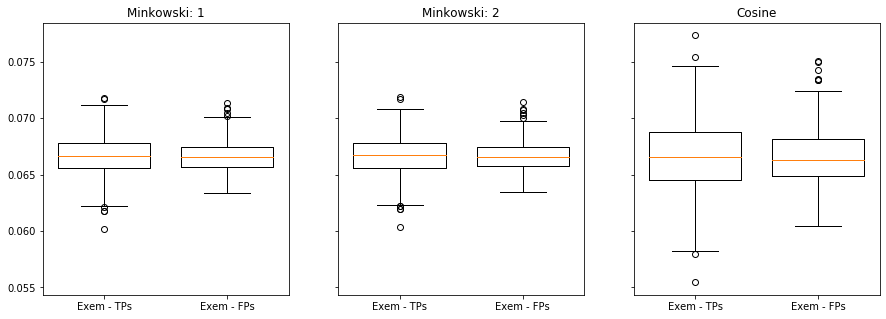

In [15]:
plot_distances(dists_mat_1, dists_mat_2, dists_mat_3,
               dists_mat_4, dists_mat_5, dists_mat_6)

## Crops of size 128x128

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [16]:
dists_mat_7 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'TP', metric='minkowski', p=1)

##### Minkowski: 2

In [17]:
dists_mat_8 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'TP', metric='minkowski', p=2)

#### Cosine

In [18]:
dists_mat_9 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'TP', metric='cosine')

### Average distance: Exemplar to FPs

##### Minkowski: 1

In [19]:
dists_mat_10 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'FP', metric='minkowski', p=1)

##### Minkowski: 2

In [20]:
dists_mat_11 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'FP', metric='minkowski', p=2)

##### Cosine

In [21]:
dists_mat_12 = get_distances(exemplars_df, detections_set, logos_128_small_df, 'FP', metric='cosine')

### Results

In [22]:
dists_mat_7.describe()

,mean,min,max,std,var
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,57.257216,48.904228,63.527660,2.478551,6.674561
std,1.662478,4.465059,1.674422,0.730561,5.144963
min,51.563222,29.950627,59.213412,1.595445,2.545443
25%,56.338789,46.066947,62.267266,1.982202,3.929123
50%,57.253472,50.379270,63.478364,2.297612,5.279022
75%,58.290514,52.225927,64.656484,2.772702,7.687875
max,61.435692,56.130308,68.392787,7.513262,56.449103


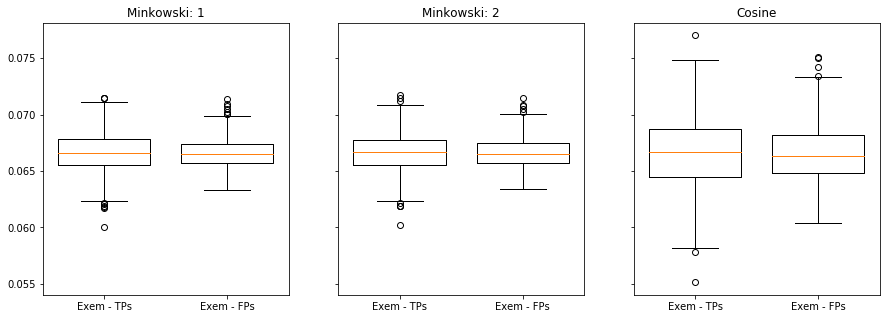

In [23]:
plot_distances(dists_mat_7, dists_mat_8, dists_mat_9,
               dists_mat_10, dists_mat_11, dists_mat_12)